# Init

In [1726]:
import datetime
import numpy as np
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

# Read the data

In [1727]:
df = pd.read_csv(
    "../data/train_data_cleaned.csv",
    # Note: some of the variables should be treated as 
    dtype={"year_week": str, "recipe_id": str},
)
df.head()

,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales
0,201801,14919,Shrimp & Broccol...,2 person,687.0,99.2,time_level_4,asian,"For this dish, o...",easy,fish,optional_heat,18.6,No,7,shellfish,rice,"fish_and_side,st...",all_seasons,shellfish,29.5,main,NaN,healthy_choice,0.0,NaN,3567
1,201801,14920,Caramelized Cabb...,2 person,779.0,81.3,time_level_4,new_american,Red lentil penne...,easy,veggie,no_heat,38.5,No,5,no_protein,pasta_incl_gnocc...,pasta,all_seasons,no_protein,30.0,main,NaN,quick,0.0,no_cut,2532
2,201801,14449,AFC Vegetarian P...,z_amazon,642.0,92.8,NaN,NaN,Pad Thai is one ...,easy,veggie,NaN,25.6,No,10,NaN,NaN,NaN,NaN,NaN,16.2,NaN,NaN,NaN,NaN,NaN,6
3,201801,11963,Shrimp & Broccol...,family,620.0,93.2,time_level_4,asian,"For this dish, o...",easy,fish,optional_heat,13.7,No,7,shellfish,rice,"fish_and_side,st...",all_seasons,shellfish,28.7,main,NaN,healthy_choice,0.0,NaN,642
4,201801,14914,Chicken & Pasta ...,family,610.0,67.0,time_level_4,new_american,We've never met ...,easy,meat,no_heat,20.0,No,7,poultry,"sweet_potato,pas...",soup,all_seasons,poultry,36.0,main,NaN,healthy_choice,0.0,breast,1492


In [1728]:
df["recipe_name_clean"] = (df
    .recipe_name
    .str.replace("&", "and").str.replace("-", " ")
    .apply(lambda text: text.lower().strip())
    # Based on the analysis, it can make sense to matches these cases
    .replace({
        "chile-lime fish tacos": "chili-lime fish tacos",
        "spicy shrimp noodles": "spicy shrimp ramen",
        "grilled berkshire pork": "grilled pork wraps",
        "spiced berkshire pork": "spiced pork tenderloin steaks",
        "moroccan pork tenderloin": "moroccan-spiced berkshire pork",
        "orecchiette and sausage": "orecchiette & sausage",
    })
)

# Functions

In [1729]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [1808]:
def clean_data(df):
    df["week_day"] = df.year_week.apply(
        lambda year_week: datetime.datetime.strptime(year_week + '-1', "%G%V-%u")
    )
    df = df.merge(
        (df
            .groupby("year_week")
            .agg({"recipe_id": "count"})
            .rename(columns={"recipe_id": "n_products"})
        ),
        how="left",
        left_on="year_week",
        right_index=True,
    )
    df = df.sort_values(["year_week", "product_type"])
    return df

# Train/validation split

In [1809]:
date_start = "201936"
date_end = "201944"

# date_start = "201928"
# date_end = "201936"

# date_start = "201920"
# date_end = "201928"

df_clean = clean_data(df.copy())
df_train = df_clean[df_clean.year_week <= date_start]
print(df_train.shape)

df_validation = df_clean[(df_clean.year_week > date_start) & (df_clean.year_week <= date_end)]
print(df_validation.shape)

assert len(df_validation.year_week.unique()) == 8, len(df_validation.year_week.unique())

(2611, 30)
(328, 30)


# Baseline model - constant average prediction

In [1733]:
rmse(df_validation.sales, [df_train["sales"].mean()] * len(df_validation))

3782.4649535100893

In [1734]:
year_weeks = sorted(df_train.year_week.unique())
df_train_subset = df_train[df_train.year_week.isin(year_weeks[-8:])]
rmse(df_validation.sales, [df_train_subset["sales"].mean()] * len(df_validation))

3705.2563002051347

# Main model

In [1836]:
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from category_encoders.ordinal import OrdinalEncoder

categorical_features = [
    'product_type',
    'dish_type',
    'protein_cuts',
    'heat_level',
    
    'course_type',
#     "protein_cuts",
    'preferences',
    'cooking_time',
    'seasons',
]
numerical_features = [
    "proteins",
    "number_of_ingredients_per_recipe",
    "fat",
    "carbs",
    "calories",
    "n_products",
]
text_features = [
    "recipe_name_clean",
    "protein_types",
    "meta_tags",
    "carbs_content",
    
    "cuisine",
    "seasons",
    "cuisine",
    "dish_types",
    "description",
]

df_train_cleaned = df_train
df_val_cleaned = df_validation
feature_names = []

# Note: tree will work faster with ordinal encoded feature, but one hot encoded features
# make it easier to transition from models based on the numerical features to the models based
# on the decision trees. Since there is quite little data it's much more efficient to use
# one encoder for all of the experiments.
# encoder = OneHotEncoder(handle_unknown="ignore")
encoder = OrdinalEncoder(handle_unknown="ignore")
X_train = encoder.fit_transform(df_train_cleaned[categorical_features].fillna("UNK").astype(str))
X_train = np.hstack((X_train, df_train_cleaned[numerical_features].fillna(0)))
y_train = df_train_cleaned["sales"]

feature_names += categorical_features + numerical_features

X_val = encoder.transform(df_val_cleaned[categorical_features].fillna("UNK").astype(str))
X_val = np.hstack((X_val, df_val_cleaned[numerical_features].fillna(0)))
y_val = df_val_cleaned["sales"]

for text_feature in text_features:
    name_vectorizer = TfidfVectorizer(min_df=50, stop_words="english")
    X_train_name = name_vectorizer.fit_transform(df_train_cleaned[text_feature].fillna("").replace(",", " "))
    X_val_name = name_vectorizer.transform(df_val_cleaned[text_feature].fillna("").replace(",", " "))

    X_train = sparse.hstack([X_train, X_train_name])
    X_val = sparse.hstack([X_val, X_val_name])
    feature_names += [text_feature + "__" + f for f in name_vectorizer.get_feature_names()]
    
# X_train = sparse.hstack([X_train, np.array(vectors_desc_train)])
# X_val = sparse.hstack([X_val, np.array(vectors_desc_val)])

print(len(feature_names))
print(X_train.shape)
print(X_val.shape)

507
(2611, 507)
(328, 507)


In [1837]:
import lightgbm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

model = lightgbm.LGBMRegressor(
    n_estimators=300,
    num_leaves=7,
    max_depth=3,
    objective="mse",
    learning_rate=0.02,
    colsample_bytree=0.6,
    verbosity=-1,
    extra_trees=True,
)

model.fit(
    X_train,
    y_train,
    # Note: sample_weight helps to add more importance to the most recent obsevations
    sample_weight=((df_train_cleaned.week_day - df_train_cleaned.week_day.min()).dt.days + 1) ** 6,
)
y_predicted = np.clip(model.predict(X_val), 0, np.inf)
rmse(y_val, y_predicted)

Converting data to scipy sparse matrix.


2960.281846349332

In [1745]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.preprocessing import StandardScaler
# model2 = MLPRegressor((300, 50), verbose=True, max_iter=200)
# model2.fit(X_train, y_train)
# y_predicted = model2.predict(X_val)
# print(rmse(y_val, y_predicted))

## Explore model's predictions

In [1746]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 20)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


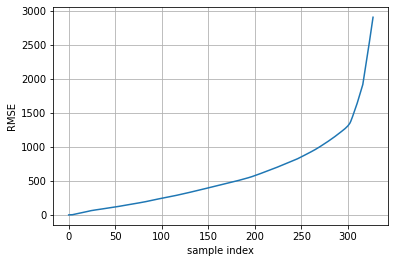

In [1747]:
df_validation["sales_predicted"] = y_predicted
df_validation["diff"] = (y_predicted - y_val).abs()
df_validation = df_validation.sort_values("diff")

cum_errors = np.sqrt(((df_validation["diff"] ** 2).cumsum() / (np.arange(len(df_validation)) + 1)))
plt.plot(cum_errors.values)
plt.grid()

plt.ylabel("RMSE")
plt.xlabel("sample index");

In [1748]:
df_pred = pd.DataFrame({"predicted_sales": y_predicted, "week_day": df_validation.week_day})
df_pred.head()

,predicted_sales,week_day
2615,1717.970077,2019-09-09
2915,1271.676494,2019-10-28
2883,1290.527407,2019-10-21
2931,3209.962400,2019-10-28
2898,2167.155821,2019-10-21


In [1564]:
df_pred.groupby(["week_day"]).predicted_sales.sum()

week_day
2019-09-09     82274.385433
2019-09-16     74037.400470
2019-09-23     85770.680314
2019-09-30    106870.530137
2019-10-07     80049.824930
2019-10-14     60622.586602
2019-10-21     87959.962871
2019-10-28     92049.078790
Name: predicted_sales, dtype: float64

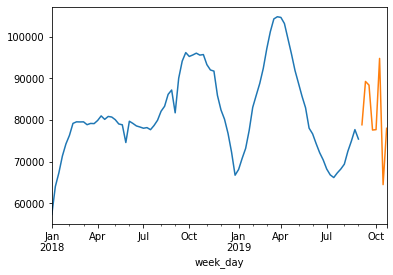

In [1749]:
ax = df_train.groupby(["week_day"]).sales.sum().plot();
df_pred.groupby(["week_day"]).predicted_sales.sum().plot(ax=ax);

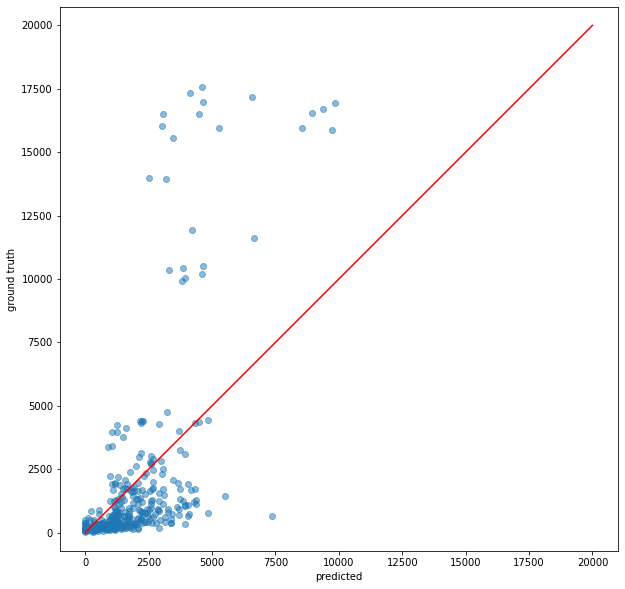

In [1750]:
plt.figure(figsize=(10, 10))
plt.scatter(y_predicted, y_val, alpha=0.5)
plt.plot([0, 20_000], [0, 20_000], color="red")
plt.xlabel("predicted")
plt.ylabel("ground truth")
plt.axis("equal");

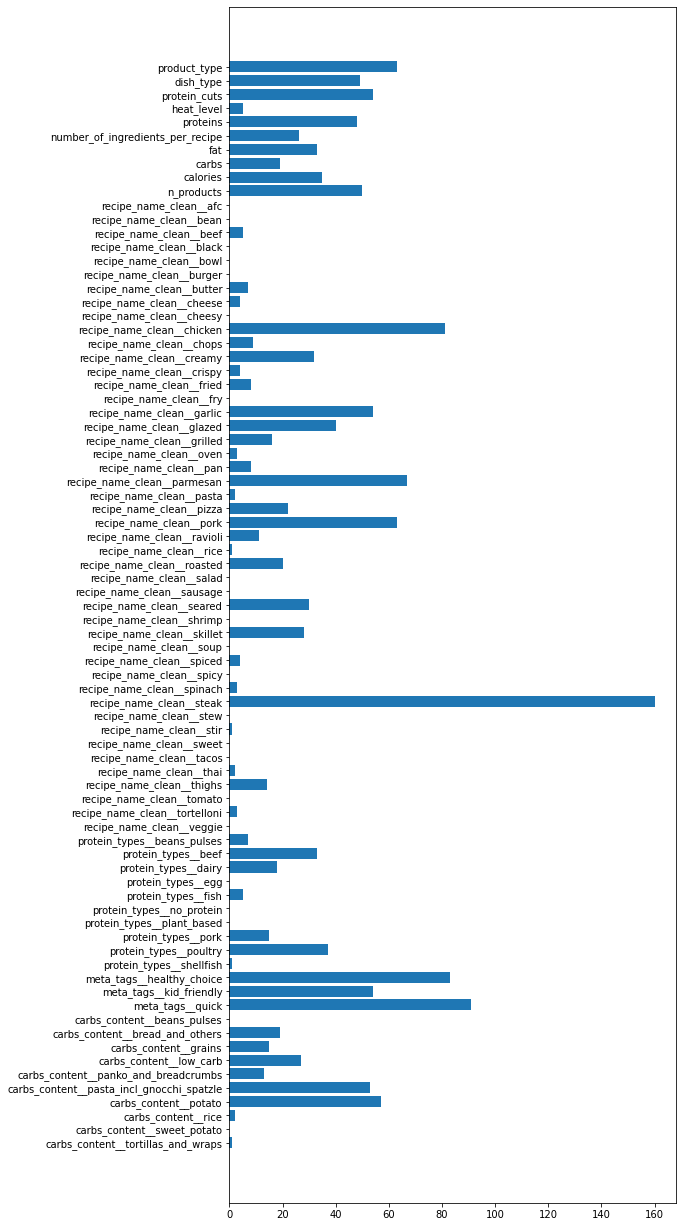

In [1751]:
xs = np.arange(len(model.feature_importances_))[::-1]
plt.figure(figsize=(8, 22))
plt.barh(xs, model.feature_importances_)
plt.yticks(xs, feature_names);

# Make one prediction per each week

In [1753]:
import shap
shap.initjs()

In [1754]:
X = sparse.vstack([X_train, X_val])
y = np.concatenate([y_train, y_val])

In [1755]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

Converting data to scipy sparse matrix.


In [1756]:
import random

val_indices = -1 * np.arange(1, len(y_val) + 1)
index, = random.sample(val_indices.tolist(), k=1)
print(y[index])

shap.force_plot(
    explainer.expected_value,
    shap_values[index, :].A,
    X.A[index,:],
    feature_names=feature_names,
)

183


In [1757]:
n_largest_errors = 10
diff = (y_predicted - y_val).abs().values
largest_error_indices = diff.argsort()[::-1]

for index in largest_error_indices[:n_largest_errors]:
    print("Ground truth:", y_val.values[index])
    print("Prediction:", y_predicted[index].astype(int))
    
    display(df_validation.iloc[[index]].drop(columns=["description"]))
    print(df_validation.iloc[index].recipe_name)
    print("-" * 20)
    print(df_validation.iloc[index].description)
    
    display(
        shap.force_plot(
            explainer.expected_value,
            shap_values[-len(y_val):][index, :].A,
            X.A[-len(y_val):][index,:],
            feature_names=feature_names,
        )
    )

Ground truth: 16520
Prediction: 3065


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2664,201938,36297,Crispy-Skinned B...,2 person,720.0,41.0,time_level_4,mediterranean,easy,fish,no_heat,44.0,No,9,fish,pasta_incl_gnocc...,fish_and_side,NaN,fish,41.0,main,NaN,quick,0.0,NaN,1337,crispy skinned b...,2019-09-16,42,1986.142476,649.142476


Crispy-Skinned Berbere Salmon
--------------------
Tired of the same old salmon recipes? We hear you. That's why we add some new pizzazz to these salmon fillets with a sprinkle of berbere—an Ethiopian spice blend that includes chile, garlic, fenugreek and warm spices, such as allspice and cinnamon. The flavors are a great match for a rich fish like salmon, which also goes great with the tomato-olive salsa, buttery orzo pilaf, and arugula salad.


Ground truth: 17346
Prediction: 4126


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2803,201941,36842,Pork Souvlaki Ke...,family,510.0,44.0,time_level_4,greek,easy,meat,no_heat,21.0,No,11,pork,bread_and_others,"meat_and_side,on...","summer,bbq",pork,38.0,main,NaN,"kid_friendly,hea...",0.0,NaN,1902,pork souvlaki ke...,2019-10-07,40,1662.479101,239.520899


Pork Souvlaki Kebabs
--------------------
No grill or grill pan? Preheat the broiler to high with a rack 6 inches from the heat. Place skewers on a rimmed baking sheet and broil on the top rack, turning them occasionally, until lightly charred, 8–10 minutes. Broil pitas directly on the rack, turning them occasionally, until lightly toasted, 1–3 minutes.


Ground truth: 16014
Prediction: 3015


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2920,201944,38283,Lemon-Chicken Dr...,2 person,950.0,52.0,time_level_5,new_american,easy,meat,no_heat,50.0,No,6,poultry,potato,"meat_and_side,on...",NaN,poultry,73.0,main,NaN,"healthy_choice,k...",0.0,NaN,663,lemon chicken dr...,2019-10-28,40,4060.065959,3397.065959


Lemon-Chicken Drumsticks
--------------------
One-pan dinners mean easy clean-up—and the best ones offer a nice variety of flavors and colors on the plate. We toss potatoes and chicken with garlic, lemon, and Kashmiri chili powder, which adds warm heat and a vibrant hue. Once seasoned, all is roasted in one skillet until perfectly golden and crisp. Hearty Tuscan kale is tossed into the mix just at the end.


Ground truth: 17556
Prediction: 4622


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2935,201944,38196,Ricotta & Mushro...,family,760.0,46.0,time_level_5,italian,easy,veggie,no_heat,54.0,No,6,dairy,pasta_incl_gnocc...,pasta,NaN,dairy,25.0,main,NaN,kid_friendly,0.0,NaN,374,ricotta and mush...,2019-10-28,40,1351.729552,977.729552


Ricotta & Mushroom Cannelloni
--------------------
Cannelloni is comfort food straight out of central casting. Tender fresh lasagna sheets are rolled around an earthy mushroom and fresh ricotta filling, and then blanketed in a creamy mascarpone sauce. Roasted broccoli makes the perfect crisp, green side for the super-rich pasta.


Ground truth: 16969
Prediction: 4646


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2647,201937,35936,Sheet-Pan Chicke...,2 person,540.0,39.0,time_level_5,mediterranean,easy,meat,no_heat,24.0,No,6,poultry,low_carb,"meat_and_side,on...",NaN,poultry,42.0,main,NaN,healthy_choice,0.0,NaN,733,sheet pan chicke...,2019-09-09,42,2769.550881,2036.550881


Sheet-Pan Chicken Thighs
--------------------
The end of summer may be sad for some, but it also means that peak grape season is upon us! Roasting grapes is a great way to bring out their natural sweetness, making them juicy and jammy. The sweetness of the grapes is balanced out perfectly by roasting them with seasoned chicken thighs, carrots, shallots, garlic, and fresh thyme.


Ground truth: 15544
Prediction: 3458


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2914,201944,38201,Tomato & Pesto T...,2 person,830.0,62.0,time_level_4,italian,easy,veggie,no_heat,55.0,No,6,dairy,pasta_incl_gnocc...,pasta,NaN,dairy,24.0,main,NaN,"kid_friendly,quick",0.0,NaN,2355,tomato and pesto...,2019-10-28,40,2386.30949,31.30949


Tomato & Pesto Tortelloni Bake
--------------------
We love any and all pastas, but too often we have to choose between pesto or tomato sauce. This dream dish offers the best of both worlds, by combining tomatoes and flavorful basil pesto. The cheese tortelloni is baked in the combined sauce, and then topped with grated Parmesan and more pesto. A crisp red leaf salad is served alongside.


Ground truth: 16498
Prediction: 4497


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2889,201943,36034,Rosemary Monster...,2 person,1030.0,51.0,time_level_4,american,easy,meat,no_heat,64.0,No,8,"pork,poultry",grains,meat_and_side,autumn,"pork,poultry",59.0,main,NaN,"kid_friendly,qui...",0.0,chops_bone_in,1739,rosemary monster...,2019-10-21,40,3054.52132,1315.52132


Rosemary Monster Pork Chop
--------------------
When there's a chill in the air, we have a mammoth appetite and a regular-size cut of meat just won't do. So we sear giant, or monster, bone-in pork chops and partner them with fall's best sides: cheesy, comforting polenta and roasted balsamic Brussels sprouts. This is a meal that's big in size, as well as flavor.


Ground truth: 13986
Prediction: 2497


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2616,201937,35957,Red Curry Tofu &...,family,540.0,51.0,time_level_5,asian_fusion,easy,veggie,no_heat,24.0,No,9,tofu_or_similar,rice_noodles,noodle,NaN,tofu_or_similar,32.0,main,NaN,healthy_choice,0.0,NaN,110,red curry tofu a...,2019-09-09,42,76.464158,33.535842


Red Curry Tofu & Rice Noodles
--------------------
Red curry paste, a staple ingredient in Thai cooking, is a vibrant blend of finely ground red chiles, lemongrass, garlic, shallots, coriander, and other spices. Unlike dried curry powder, curry paste utilizes fresh ingredients, and adds a brightness to curries, like this sauce for vegetarian noodles studded with carrots and crisp snow peas.


Ground truth: 13926
Prediction: 3182


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2925,201944,38185,Brazilian Coconu...,2 person,1000.0,151.0,time_level_5,central_south_am...,easy,veggie,no_heat,39.0,No,10,beans_pulses,sweet_potato,stew,NaN,beans_pulses,22.0,main,NaN,healthy_choice,0.0,NaN,589,brazilian coconu...,2019-10-28,40,1034.935497,445.935497


Brazilian Coconut Vegetable Stew
--------------------
Moqueca is a traditional seafood stew made with creamy coconut milk, tomatoes, and lime juice.  This vegetarian version packs the same punch, but is loaded with hearty chickpeas and veggies, like eggplant and sweet potatoes. Here, it is served over fluffy jasmine rice, with fresh lime wedges to squeeze on top for a zippy, citrusy finish.


Ground truth: 15967
Prediction: 5284


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2855,201942,36993,Sausage & Ricott...,2 person,1230.0,53.0,time_level_5,italian,easy,meat,no_heat,88.0,No,9,"dairy,pork",pasta_incl_gnocc...,"pasta,one_pot",NaN,"dairy,pork",53.0,main,NaN,kid_friendly,0.0,ground_mince,1280,sausage and rico...,2019-10-14,40,2646.495859,1366.495859


Sausage & Ricotta Lasagna
--------------------
Lasagna has a reputation for being high-maintenance and time-consuming but this skillet version comes together quicker than you can say, "that's amore."  The filling is a flavor-packed combo of Italian sausage and creamy ricotta. We layer it with caramelized tomato sauce and fresh sheets of pasta, which require no pre-boiling. The result is a weeknight-friendly dish that tastes as if it's been cooking for hours.


In [1758]:
n_largest_prdictions = 10
diff = y_predicted
largest_value_indices = diff.argsort()[::-1]

for index in largest_value_indices[:n_largest_prdictions]:
    print("Ground truth", y_val.values[index])
    print("Prediction", y_predicted[index].astype(int))
    display(df_validation.iloc[[index]].drop(columns=["description"]))
    print(df_validation.iloc[index].recipe_name)
    print("-" * 20)
    print(df_validation.iloc[index].description)
    display(
        shap.force_plot(
            explainer.expected_value,
            shap_values[-len(y_val):][index, :].A,
            X.A[-len(y_val):][index,:],
            feature_names=feature_names,
        )
    )

Ground truth 16944
Prediction 9853


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2780,201941,36853,Beef Tacos,2 person,960.0,80.0,time_level_4,mexican,easy,meat,no_heat,55.0,No,9,beef,tortillas_and_wraps,"one_pot,tacos_to...",all_seasons,beef,42.0,main,NaN,"kid_friendly,hea...",0.0,ground_mince,953,beef tacos,2019-10-07,40,1893.151703,940.151703


Beef Tacos
--------------------
What is it about taco night that makes dinnertime more fun? Is it eating with your hands? All the margaritas? Whatever the reason, here's a tip to make it not just fun but easier on your wrists: Roll the whole lime between your palm and a hard surface. It helps to burst the individual segments inside, making it simpler to squeeze the lime juice after cutting.


Ground truth 15892
Prediction 9712


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2848,201942,37049,Oven-Roasted Cod,2 person,620.0,79.0,time_level_3,european,easy,fish,no_heat,16.0,No,6,fish,bread_and_others,"fish_and_side,on...",all_seasons,fish,38.0,main,NaN,"quick,healthy_ch...",0.0,fillet,1121,oven roasted cod,2019-10-14,40,1347.438726,226.438726


Oven-Roasted Cod
--------------------
We're holding on to the bright, fresh flavors of summer with this dish. We combine delicate roasted cod with tender zucchini, about-to-burst tomatoes, and crusty garlic bread. The finishing touch is chimichurri, a zippy sauce made from parsley, cilantro, garlic, vinegar, and spices—a condiment that's sure to punch up any meal.


Ground truth 16694
Prediction 9384


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2756,201940,36634,Chicken Fajita Bowl,family,630.0,49.0,time_level_4,new_american,easy,meat,no_heat,30.0,No,9,poultry,rice,meat_and_side,all_seasons,poultry,41.0,main,NaN,"kid_friendly,hea...",0.0,breast,4260,chicken fajita bowl,2019-09-30,42,1249.211525,3010.788475


Chicken Fajita Bowl
--------------------
Fajitas are a pretty perfect meal. Except when you wrap one up and take a bite, only to have it all fall out of the other end of the tortilla. Problem solved! Enter the fajita bowl. We've layered brown rice, sautéed peppers, and taco-spiced chicken breast, and topped it with fresh cilantro and a drizzle of sour cream. You'll get all the flavors of the sizzling dish in each tidy forkful.


Ground truth 16548
Prediction 8956


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2686,201938,36473,Chicken Tortilla...,family,534.0,61.5,time_level_4,mexican,easy,meat,high,18.8,No,9,"poultry,spicy",tortillas_and_wraps,soup,NaN,poultry,30.0,main,NaN,"healthy_choice,q...",0.0,NaN,297,chicken tortilla...,2019-09-16,42,1005.028202,708.028202


Chicken Tortilla Soup
--------------------
Chicken soup is always the cure for whatever ails you, and this spicy chicken tortilla soup is definitely the antidote to the midweek blues! Tender pieces of chicken are simmered in a deeply flavored broth, that delivers a nice bit of heat from the Mexican chili spice blend. The real kicker is the crispy tortilla strips piled on top for texture. This soup is sure to liven up the night.


Ground truth 15950
Prediction 8542


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2696,201939,36441,Berbere Chicken ...,2 person,640.0,29.0,time_level_5,mediterranean,easy,meat,no_heat,40.0,No,8,poultry,low_carb,"meat_and_side,on...",NaN,poultry,44.0,main,NaN,healthy_choice,0.0,NaN,901,berbere chicken ...,2019-09-23,42,2871.72909,1970.72909


Berbere Chicken Thighs
--------------------
Berbere is a traditional Ethiopian seasoning blend made from chiles, garlic, and spices, like fenugreek, allspice, and cinnamon—it's also the shining star of this comforting chicken dish, brimming with early fall flavors. The chicken thighs are served with sweet roasted red onions and butternut squash, all drizzled with a luscious tahini sauce. Pomegranate seeds add a colorful crunch to the dish, giving each bite a sweet pop.


Ground truth 666
Prediction 7353


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2854,201942,36994,Sausage & Ricott...,family,940.0,49.0,time_level_6,italian,easy,meat,no_heat,62.0,No,9,"dairy,pork",pasta_incl_gnocc...,"pasta,one_pot",NaN,"dairy,pork",44.0,main,NaN,kid_friendly,0.0,ground_mince,380,sausage and rico...,2019-10-14,40,1096.954233,716.954233


Sausage & Ricotta Lasagna
--------------------
Lasagna has a reputation for being high-maintenance and time-consuming but this skillet version comes together quicker than you can say, "that's amore."  The filling is a flavor-packed combo of Italian sausage and creamy ricotta. We layer it with caramelized tomato sauce and fresh sheets of pasta, which require no pre-boiling. The result is a weeknight-friendly dish that tastes as if it's been cooking for hours.


Ground truth 11631
Prediction 6641


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2655,201938,36160,Cheesy BBQ Beef ...,2 person,580.0,65.0,time_level_5,new_american,easy,meat,no_heat,46.0,No,9,"beef,dairy",low_carb,meat_and_side,NaN,"beef,dairy",43.0,main,NaN,kid_friendly,0.0,NaN,3016,cheesy bbq beef ...,2019-09-16,42,2587.197733,428.802267


Cheesy BBQ Beef Meatballs
--------------------
This recipe is all that and a plate of fries. Literally. Imagine juicy, cheese-stuffed meatballs coated in your favorite classic BBQ sauce, then broiled till delectably glazed. They're partnered with veggie fries that you can dip in our not-so-secret special sauce. This one goes out to all the picky eaters out there.


Ground truth 17174
Prediction 6558


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2707,201939,36519,Skillet Chicken ...,family,1040.0,98.0,time_level_5,new_american,easy,meat,no_heat,37.0,No,7,poultry,pasta_incl_gnocc...,"pasta,meat_and_side",all_seasons,poultry,69.0,main,NaN,kid_friendly,0.0,breast,4445,skillet chicken ...,2019-09-23,42,4832.906716,387.906716


Skillet Chicken Parmesan
--------------------
We're giving chicken Parmesan a minimalist makeover. We're taking out the hard work by leaving behind the flour-egg-breadcrumbs step, but obviously keeping the melty mozzarella. And unless you were looking forward to washing extra pots and pans, you'll be happy to find that all you'll need is a skillet for the chicken and a pot for the pasta.


Ground truth 1438
Prediction 5495


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2933,201944,38194,Garlic & Herb Cod,family,710.0,67.0,time_level_4,mediterranean,easy,fish,no_heat,33.0,No,8,fish,bread_and_others,fish_and_side,NaN,fish,37.0,main,NaN,"quick,healthy_ch...",0.0,NaN,124,garlic and herb cod,2019-10-28,40,2077.936766,1953.936766


Garlic & Herb Cod
--------------------
This simple weeknight dinner comes together in under 30 minutes, all in one pan. Those are reasons enough to love it, but it also packs a seriously bold flavor punch, thanks to the smoked paprika, fresh thyme, garlic, and lemon that season the fish and vegetables. There will be plenty of lemony dressing leftover— the perfect dip for toasted ciabatta served alongside.


Ground truth 15967
Prediction 5284


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products,sales_predicted,diff
2855,201942,36993,Sausage & Ricott...,2 person,1230.0,53.0,time_level_5,italian,easy,meat,no_heat,88.0,No,9,"dairy,pork",pasta_incl_gnocc...,"pasta,one_pot",NaN,"dairy,pork",53.0,main,NaN,kid_friendly,0.0,ground_mince,1280,sausage and rico...,2019-10-14,40,2646.495859,1366.495859


Sausage & Ricotta Lasagna
--------------------
Lasagna has a reputation for being high-maintenance and time-consuming but this skillet version comes together quicker than you can say, "that's amore."  The filling is a flavor-packed combo of Italian sausage and creamy ricotta. We layer it with caramelized tomato sauce and fresh sheets of pasta, which require no pre-boiling. The result is a weeknight-friendly dish that tastes as if it's been cooking for hours.


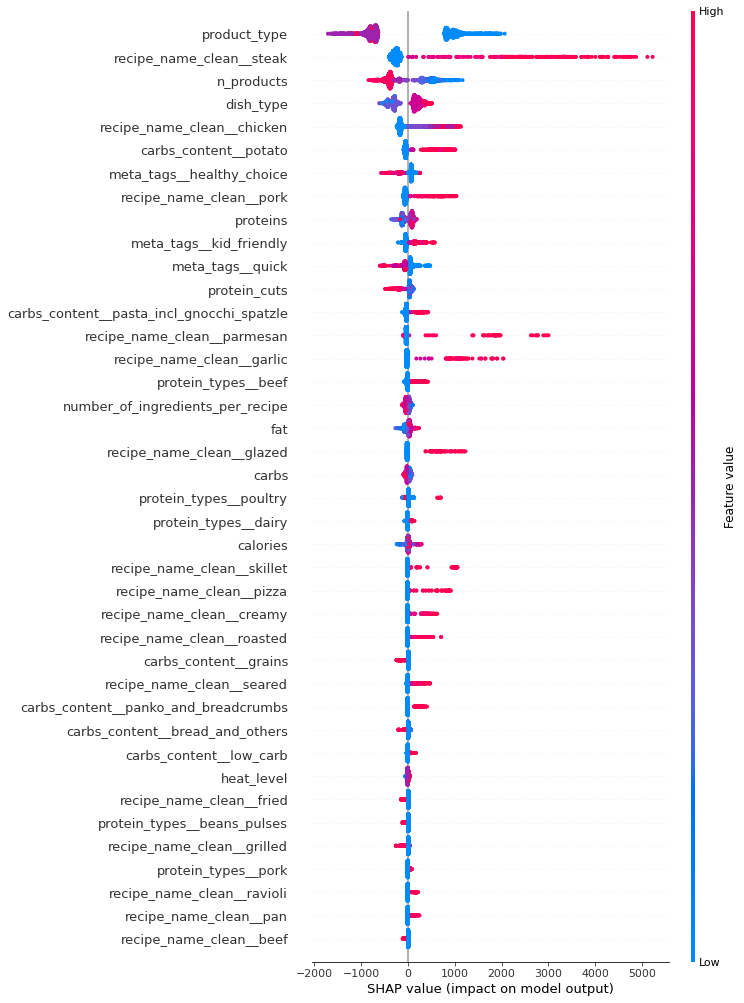

In [1759]:
shap.summary_plot(shap_values.A, X.A, feature_names=feature_names, max_display=40)

# Ranking model

In [1815]:
df_groups_train = df_train.groupby(["year_week", "product_type"]).recipe_id.first().reset_index()
df_groups_train["group_id"] = np.arange(len(df_groups_train))

df_groups_val = df_validation.groupby(["year_week", "product_type"]).recipe_id.first().reset_index()
df_groups_val["group_id"] = np.arange(len(df_groups_val))

In [1816]:
df_validation

,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products
2611,201937,35978,Broken Noodle Pa...,2 person,810.0,113.0,time_level_4,european,We riff on the i...,easy,veggie,no_heat,29.0,No,9,beans_pulses,pasta_incl_gnocc...,pasta,NaN,beans_pulses,27.0,main,NaN,quick,0.0,NaN,871,broken noodle pa...,2019-09-09,42
2614,201937,35972,Late Summer Grai...,2 person,930.0,119.0,time_level_4,new_american,This bowl is a c...,easy,veggie,no_heat,40.0,No,10,dairy,gluten_free_grai...,grains,summer,dairy,27.0,main,NaN,healthy_choice,0.0,NaN,537,late summer grai...,2019-09-09,42
2617,201937,35956,Red Curry Tofu &...,2 person,550.0,51.0,time_level_5,asian_fusion,"Red curry paste,...",easy,veggie,no_heat,25.0,No,9,tofu_or_similar,rice_noodles,noodle,NaN,tofu_or_similar,32.0,main,NaN,healthy_choice,0.0,NaN,673,red curry tofu a...,2019-09-09,42
2619,201937,35974,Chicken Piccata ...,2 person,800.0,16.0,time_level_5,italian,Low carb doesn't...,easy,meat,no_heat,64.0,No,9,"dairy,poultry",low_carb,meat_and_side,NaN,"dairy,poultry",38.0,main,NaN,"kid_friendly,hea...",0.0,NaN,4755,chicken piccata ...,2019-09-09,42
2620,201937,35980,Gnocchi with Cre...,2 person,700.0,61.0,time_level_3,new_american,Gnocchi are like...,easy,veggie,no_heat,46.0,No,8,dairy,pasta_incl_gnocc...,"pasta,one_pot",all_seasons,dairy,15.0,main,NaN,quick,0.0,no_cut,848,gnocchi with cre...,2019-09-09,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2930,201944,38190,Korean Beef Bulg...,family,850.0,78.0,time_level_4,asian_fusion,Bulgogi is a tra...,easy,meat,optional_heat,43.0,No,9,beef,rice,"meat_and_side,rice",NaN,beef,35.0,main,NaN,"healthy_choice,k...",0.0,NaN,370,korean beef bulg...,2019-10-28,40
2931,201944,38192,Caramel Tofu,family,640.0,83.0,time_level_4,chinese,We like to think...,easy,veggie,no_heat,21.0,No,8,tofu_or_similar,rice,"stir_fry,rice",NaN,tofu_or_similar,31.0,main,NaN,"healthy_choice,q...",0.0,NaN,48,caramel tofu,2019-10-28,40
2933,201944,38194,Garlic & Herb Cod,family,710.0,67.0,time_level_4,mediterranean,This simple week...,easy,fish,no_heat,33.0,No,8,fish,bread_and_others,fish_and_side,NaN,fish,37.0,main,NaN,"quick,healthy_ch...",0.0,NaN,124,garlic and herb cod,2019-10-28,40
2935,201944,38196,Ricotta & Mushro...,family,760.0,46.0,time_level_5,italian,Cannelloni is co...,easy,veggie,no_heat,54.0,No,6,dairy,pasta_incl_gnocc...,pasta,NaN,dairy,25.0,main,NaN,kid_friendly,0.0,NaN,374,ricotta and mush...,2019-10-28,40


In [1817]:

from collections import Counter

def count_groups(df, df_groups):
    group_ids = df.merge(
        df_groups.drop(columns=["recipe_id"]),
        how="left", on=["year_week", "product_type"]
    ).group_id.values
    counts = Counter(group_ids)
    groups = [v for k, v in sorted(counts.items())]  # sort based on keys
    return groups

train_groups = count_groups(df_train, df_groups_train)
val_groups = count_groups(df_validation, df_groups_val)

In [1818]:
df_validation

,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products
2611,201937,35978,Broken Noodle Pa...,2 person,810.0,113.0,time_level_4,european,We riff on the i...,easy,veggie,no_heat,29.0,No,9,beans_pulses,pasta_incl_gnocc...,pasta,NaN,beans_pulses,27.0,main,NaN,quick,0.0,NaN,871,broken noodle pa...,2019-09-09,42
2614,201937,35972,Late Summer Grai...,2 person,930.0,119.0,time_level_4,new_american,This bowl is a c...,easy,veggie,no_heat,40.0,No,10,dairy,gluten_free_grai...,grains,summer,dairy,27.0,main,NaN,healthy_choice,0.0,NaN,537,late summer grai...,2019-09-09,42
2617,201937,35956,Red Curry Tofu &...,2 person,550.0,51.0,time_level_5,asian_fusion,"Red curry paste,...",easy,veggie,no_heat,25.0,No,9,tofu_or_similar,rice_noodles,noodle,NaN,tofu_or_similar,32.0,main,NaN,healthy_choice,0.0,NaN,673,red curry tofu a...,2019-09-09,42
2619,201937,35974,Chicken Piccata ...,2 person,800.0,16.0,time_level_5,italian,Low carb doesn't...,easy,meat,no_heat,64.0,No,9,"dairy,poultry",low_carb,meat_and_side,NaN,"dairy,poultry",38.0,main,NaN,"kid_friendly,hea...",0.0,NaN,4755,chicken piccata ...,2019-09-09,42
2620,201937,35980,Gnocchi with Cre...,2 person,700.0,61.0,time_level_3,new_american,Gnocchi are like...,easy,veggie,no_heat,46.0,No,8,dairy,pasta_incl_gnocc...,"pasta,one_pot",all_seasons,dairy,15.0,main,NaN,quick,0.0,no_cut,848,gnocchi with cre...,2019-09-09,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2930,201944,38190,Korean Beef Bulg...,family,850.0,78.0,time_level_4,asian_fusion,Bulgogi is a tra...,easy,meat,optional_heat,43.0,No,9,beef,rice,"meat_and_side,rice",NaN,beef,35.0,main,NaN,"healthy_choice,k...",0.0,NaN,370,korean beef bulg...,2019-10-28,40
2931,201944,38192,Caramel Tofu,family,640.0,83.0,time_level_4,chinese,We like to think...,easy,veggie,no_heat,21.0,No,8,tofu_or_similar,rice,"stir_fry,rice",NaN,tofu_or_similar,31.0,main,NaN,"healthy_choice,q...",0.0,NaN,48,caramel tofu,2019-10-28,40
2933,201944,38194,Garlic & Herb Cod,family,710.0,67.0,time_level_4,mediterranean,This simple week...,easy,fish,no_heat,33.0,No,8,fish,bread_and_others,fish_and_side,NaN,fish,37.0,main,NaN,"quick,healthy_ch...",0.0,NaN,124,garlic and herb cod,2019-10-28,40
2935,201944,38196,Ricotta & Mushro...,family,760.0,46.0,time_level_5,italian,Cannelloni is co...,easy,veggie,no_heat,54.0,No,6,dairy,pasta_incl_gnocc...,pasta,NaN,dairy,25.0,main,NaN,kid_friendly,0.0,NaN,374,ricotta and mush...,2019-10-28,40


In [1819]:
# y_train_rank = df_train.groupby(["year_week", "product_type"]).sales.rank(method="first").values
# y_val_rank = df_validation.groupby(["year_week", "product_type"]).sales.rank(method="first").values

In [1820]:
y_train_rank = pd.cut(df_train.sales, [0, 1000, 5000, 10000, 100000], labels=[0, 1, 2, 3]).values.astype(int)
y_val_rank = pd.cut(df_validation.sales, [0, 1000, 5000, 10000, 100000], labels=[0, 1, 2, 3]).values.astype(int)

In [1821]:
df_validation#.sales

,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,n_products
2611,201937,35978,Broken Noodle Pa...,2 person,810.0,113.0,time_level_4,european,We riff on the i...,easy,veggie,no_heat,29.0,No,9,beans_pulses,pasta_incl_gnocc...,pasta,NaN,beans_pulses,27.0,main,NaN,quick,0.0,NaN,871,broken noodle pa...,2019-09-09,42
2614,201937,35972,Late Summer Grai...,2 person,930.0,119.0,time_level_4,new_american,This bowl is a c...,easy,veggie,no_heat,40.0,No,10,dairy,gluten_free_grai...,grains,summer,dairy,27.0,main,NaN,healthy_choice,0.0,NaN,537,late summer grai...,2019-09-09,42
2617,201937,35956,Red Curry Tofu &...,2 person,550.0,51.0,time_level_5,asian_fusion,"Red curry paste,...",easy,veggie,no_heat,25.0,No,9,tofu_or_similar,rice_noodles,noodle,NaN,tofu_or_similar,32.0,main,NaN,healthy_choice,0.0,NaN,673,red curry tofu a...,2019-09-09,42
2619,201937,35974,Chicken Piccata ...,2 person,800.0,16.0,time_level_5,italian,Low carb doesn't...,easy,meat,no_heat,64.0,No,9,"dairy,poultry",low_carb,meat_and_side,NaN,"dairy,poultry",38.0,main,NaN,"kid_friendly,hea...",0.0,NaN,4755,chicken piccata ...,2019-09-09,42
2620,201937,35980,Gnocchi with Cre...,2 person,700.0,61.0,time_level_3,new_american,Gnocchi are like...,easy,veggie,no_heat,46.0,No,8,dairy,pasta_incl_gnocc...,"pasta,one_pot",all_seasons,dairy,15.0,main,NaN,quick,0.0,no_cut,848,gnocchi with cre...,2019-09-09,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2930,201944,38190,Korean Beef Bulg...,family,850.0,78.0,time_level_4,asian_fusion,Bulgogi is a tra...,easy,meat,optional_heat,43.0,No,9,beef,rice,"meat_and_side,rice",NaN,beef,35.0,main,NaN,"healthy_choice,k...",0.0,NaN,370,korean beef bulg...,2019-10-28,40
2931,201944,38192,Caramel Tofu,family,640.0,83.0,time_level_4,chinese,We like to think...,easy,veggie,no_heat,21.0,No,8,tofu_or_similar,rice,"stir_fry,rice",NaN,tofu_or_similar,31.0,main,NaN,"healthy_choice,q...",0.0,NaN,48,caramel tofu,2019-10-28,40
2933,201944,38194,Garlic & Herb Cod,family,710.0,67.0,time_level_4,mediterranean,This simple week...,easy,fish,no_heat,33.0,No,8,fish,bread_and_others,fish_and_side,NaN,fish,37.0,main,NaN,"quick,healthy_ch...",0.0,NaN,124,garlic and herb cod,2019-10-28,40
2935,201944,38196,Ricotta & Mushro...,family,760.0,46.0,time_level_5,italian,Cannelloni is co...,easy,veggie,no_heat,54.0,No,6,dairy,pasta_incl_gnocc...,pasta,NaN,dairy,25.0,main,NaN,kid_friendly,0.0,NaN,374,ricotta and mush...,2019-10-28,40


In [1838]:
import lightgbm

model = lightgbm.LGBMRanker(
    n_estimators=200,
    num_leaves=7,
    max_depth=4,
    learning_rate=0.01,
    colsample_bytree=0.5,
    verbosity=-1,
    extra_trees=True,
)

model.fit(
    X_train,
    y_train_rank,
    group=train_groups,
    # Note: sample_weight helps to add more importance to the most recent obsevations
    sample_weight=((df_train_cleaned.week_day - df_train_cleaned.week_day.min()).dt.days + 1) ** 6,
    eval_set=[(X_val, y_val_rank)],
    eval_at=[1, 5, 10, 20],
    eval_group=[val_groups],
)

[1]	valid_0's ndcg@1: 0.473214	valid_0's ndcg@5: 0.493351	valid_0's ndcg@10: 0.555517	valid_0's ndcg@20: 0.672981
[2]	valid_0's ndcg@1: 0.9375	valid_0's ndcg@5: 0.646749	valid_0's ndcg@10: 0.689057	valid_0's ndcg@20: 0.791465
[3]	valid_0's ndcg@1: 0.821429	valid_0's ndcg@5: 0.632943	valid_0's ndcg@10: 0.732577	valid_0's ndcg@20: 0.804622
[4]	valid_0's ndcg@1: 0.821429	valid_0's ndcg@5: 0.610327	valid_0's ndcg@10: 0.739026	valid_0's ndcg@20: 0.80112
[5]	valid_0's ndcg@1: 0.821429	valid_0's ndcg@5: 0.641446	valid_0's ndcg@10: 0.735978	valid_0's ndcg@20: 0.802792
[6]	valid_0's ndcg@1: 0.696429	valid_0's ndcg@5: 0.653662	valid_0's ndcg@10: 0.730491	valid_0's ndcg@20: 0.797589
[7]	valid_0's ndcg@1: 0.821429	valid_0's ndcg@5: 0.701686	valid_0's ndcg@10: 0.757465	valid_0's ndcg@20: 0.823384
[8]	valid_0's ndcg@1: 0.696429	valid_0's ndcg@5: 0.667125	valid_0's ndcg@10: 0.724947	valid_0's ndcg@20: 0.792679
[9]	valid_0's ndcg@1: 0.696429	valid_0's ndcg@5: 0.665139	valid_0's ndcg@10: 0.728395	valid

[120]	valid_0's ndcg@1: 0.9375	valid_0's ndcg@5: 0.726445	valid_0's ndcg@10: 0.747883	valid_0's ndcg@20: 0.835562
[121]	valid_0's ndcg@1: 0.9375	valid_0's ndcg@5: 0.726445	valid_0's ndcg@10: 0.747883	valid_0's ndcg@20: 0.835562
[122]	valid_0's ndcg@1: 0.9375	valid_0's ndcg@5: 0.724412	valid_0's ndcg@10: 0.745914	valid_0's ndcg@20: 0.832842
[123]	valid_0's ndcg@1: 0.9375	valid_0's ndcg@5: 0.722759	valid_0's ndcg@10: 0.743319	valid_0's ndcg@20: 0.831249
[124]	valid_0's ndcg@1: 0.9375	valid_0's ndcg@5: 0.728097	valid_0's ndcg@10: 0.748353	valid_0's ndcg@20: 0.836207
[125]	valid_0's ndcg@1: 0.9375	valid_0's ndcg@5: 0.722378	valid_0's ndcg@10: 0.742786	valid_0's ndcg@20: 0.830724
[126]	valid_0's ndcg@1: 0.9375	valid_0's ndcg@5: 0.728568	valid_0's ndcg@10: 0.748754	valid_0's ndcg@20: 0.836583
[127]	valid_0's ndcg@1: 0.9375	valid_0's ndcg@5: 0.719211	valid_0's ndcg@10: 0.738314	valid_0's ndcg@20: 0.826865
[128]	valid_0's ndcg@1: 0.9375	valid_0's ndcg@5: 0.720864	valid_0's ndcg@10: 0.739805	va

LGBMRanker(colsample_bytree=0.5, extra_trees=True, learning_rate=0.01,
           max_depth=4, n_estimators=200, num_leaves=7, verbosity=-1)

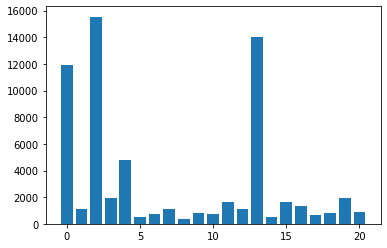

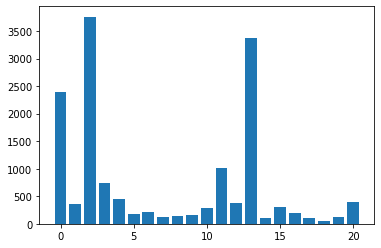

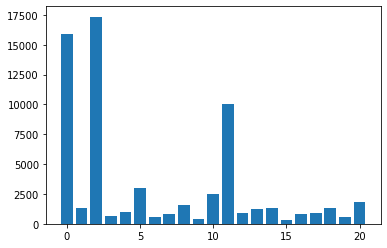

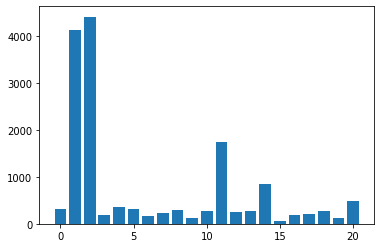

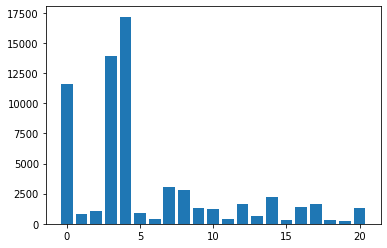

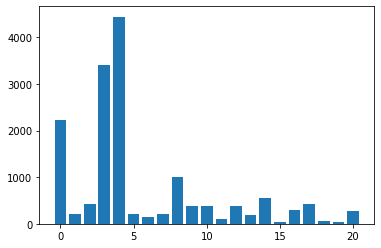

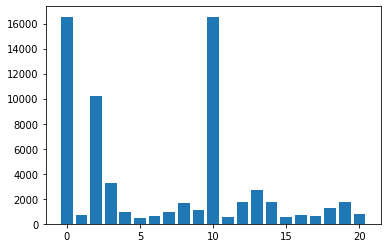

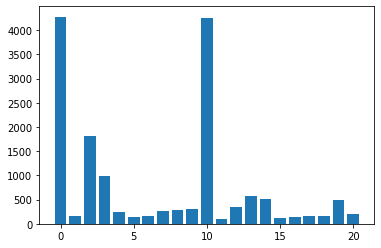

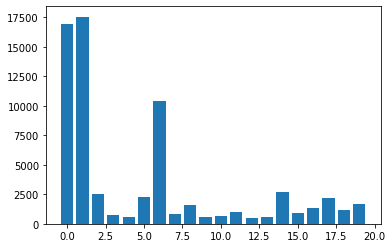

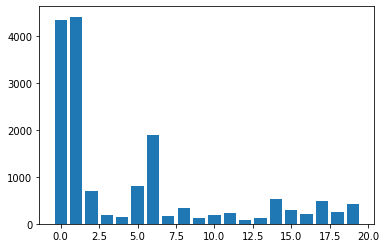

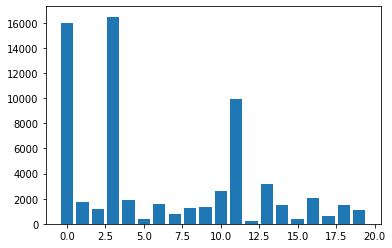

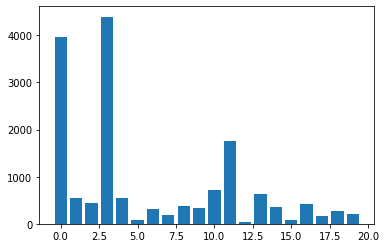

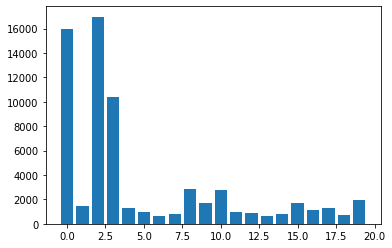

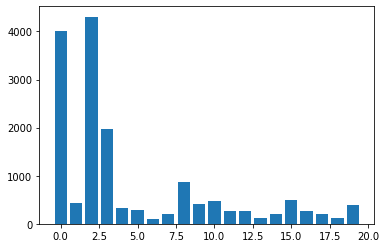

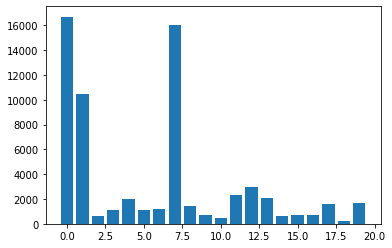

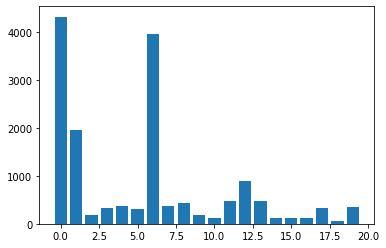

In [1839]:
y_val_partial = y_val.values
X_val_partial = X_val.A
n_checked = 0
for n_within_group in val_groups:
    res = y_val_partial[:n_within_group][np.argsort(model.predict(X_val_partial[:n_within_group]))[::-1]]
    
    plt.bar(np.arange(len(res)), res)
    plt.show()
    
    y_val_partial = y_val_partial[n_within_group:]
    X_val_partial = X_val_partial[n_within_group:]

# Sample historical examples

In [1554]:
name = pd.Series(list(set(df_train.recipe_name_clean) & set(df_validation.recipe_name_clean))).sample(1).values[0]
print(name)
display(
    df_train[df_train.recipe_name_clean == name][["year_week", "sales", "product_type", "total_sales"]].sort_values(
        ["year_week", "product_type"]
    )
)
df_validation[df_validation.recipe_name_clean == name][["year_week", "sales", "product_type", "total_sales"]].sort_values(
    ["year_week", "product_type"]
)

chicken schnitzel and potatoes


,year_week,sales,product_type,total_sales
194,201806,18211,2 person,76306
189,201806,3890,family,76306
1214,201848,3064,2 person,85879
1209,201848,793,family,85879
1546,201910,1334,2 person,97148
1549,201910,335,family,97148


,year_week,sales,product_type,total_sales
2874,201943,16969,2 person,81651
2875,201943,4306,family,81651
